In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdal
import cv2

gdal.AllRegister()

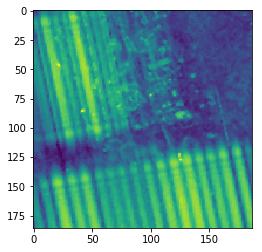

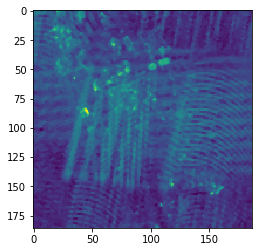

In [48]:
vh_ds = gdal.Open('./vh.tif')
vh_band = vh_ds.GetRasterBand(1)
vh = vh_band.ReadAsArray()
plt.imshow(vh)
plt.show()

vv_ds = gdal.Open('./vv.tif')
vv_band = vv_ds.GetRasterBand(1)
vv = vv_band.ReadAsArray()
plt.imshow(vv)
plt.show()

In [58]:
vh_shifted = vh - np.min(vh)
vh_scaled = vh_shifted / np.max(vh_shifted) * 255
vh_scaled = np.array(vh_scaled, dtype=np.uint8)
# threshed = cv2.adaptiveThreshold(vh_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 0)
# cv2.imwrite('VH.png', threshed)

True

In [79]:
img = np.zeros([vh.shape[0],vh.shape[1],3])

img[:,:,0] = vh_scaled
img[:,:,1] = vh_scaled
img[:,:,2] = vh_scaled

r,g,b = cv2.split(img)
img_bgr = cv2.merge([b,g,r])

img_bgr = img_bgr.astype('uint8')

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
cv2.imwrite('tmp.png', gray)

True

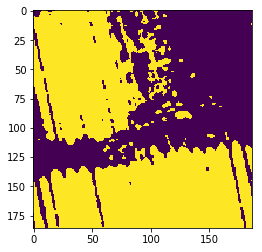

In [77]:
# (thresh, im_bw) = cv2.threshold(threshed, 100, 1, 0)
(thresh, im_bw) = cv2.threshold(gray, 100, 1, 0)
# plt.imshow(thresh)
# plt.show()
plt.imshow(im_bw)
plt.show()

cv2.imwrite('tmp.png', im_bw)
im_bw2 = cv2.imread('tmp.png')

In [78]:
im2, contours, hierarchy = cv2.findContours(im_bw2, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# cv2.drawContours(im_bw, contours, -1, (0,255,0), 3)
# plt.imshow(im,cmap='gray')

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
